# Fraud Detection in Credit Card Payments

The data used in the following notebook was obtained from Kaggle (Dal Pozzolo et al 2015). Link to the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud/data

According to the dictionary, to protect the identity, the variables in the data set are the consequence of a dimensionality reduction process (PCA). The time variable represent the number of seconds elapsed between the transaction and the first transaction in the dataset.

## Downloading the dataset

In case you cloned this repository from Amazon Sagemaker, the best way to obtain the data is to run the following lines:

```
!rm creditcard.csv
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip
!unzip creditcardfraud
!rm creditcardfraud.zip
```

Because creditcard.csv was uploaded using `lfs`, When this repository is cloned from Sagemaker, the creditcard.csv file will contain only pointers.

If you clone this repo locally and `lfs` is configured, the dataset will be correcly downloaded.

## Exploring the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!rm creditcard.csv
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip
!unzip creditcardfraud
!rm creditcardfraud.zip

rm: cannot remove ‘creditcard.csv’: No such file or directory
--2021-04-03 21:49:28--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.161.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.161.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘creditcardfraud.zip’

creditcardfraud.zip 100%[===================>]  65.95M  44.7MB/s    in 1.5s    

2021-04-03 21:49:29 (44.7 MB/s) - ‘creditcardfraud.zip’ saved [69155632/69155632]

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [4]:
data=pd.read_csv('creditcard.csv')

In [5]:
print("The dataset contains {} observations and {} features".format(data.shape[0],data.shape[1]))
data.head()

The dataset contains 284807 observations and 31 features


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Features

* V1-V28: The principal componentes obtained by PCA. The original features cannot be disclosed for confidentiality reasons.
* Time: Seconds elapsed between the transaction and the first transaction in the dataset.
* Amount: The amount of the transaction.
* Class: Takes the value of **1** if it was a fraudulent transaction and **0** otherwise.

#### Time

The data contains two days of transactions

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

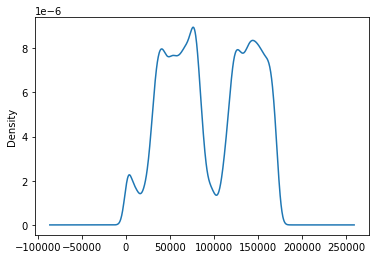

In [6]:
data.Time.plot(kind='density');
data.Time.describe()

#### PCA components

As expected, all the components of the PCA has zero correlation with each other.

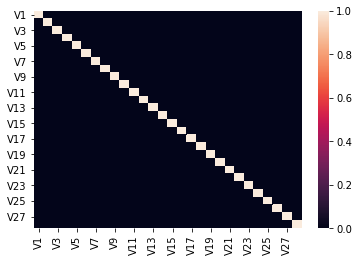

In [7]:
sns.heatmap(data.loc[:,data.columns.str.startswith('V')].corr());

#### Amount

In [8]:
data.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

#### Class

The dataset is extremely imbalanced, with only 0.17% of the observations labelled as fraudulent

In [9]:
print("Number of fraudulent transactions in the dataset: {}".format(data.Class.value_counts()[1]))
print("Proportion of fraudulent transactions in the dataset: {}%".format((data.Class.value_counts()[1]/len(data.Class))*100))

Number of fraudulent transactions in the dataset: 492
Proportion of fraudulent transactions in the dataset: 0.1727485630620034%


## Model Estimation

Our task is to detect the as many fraudulent transactions as possible. Provided that our data is extremely imbalanced, with more that 99% of the observations labelled as non-fraudulent, algorithms will generally tend to predict all transactions to be on the majority class. For this reason, we should focus on minimizing False Negatives and maximizing True Positives (maximizing Recall).

\begin{align}
Recall=\frac{TP}{TP+FN}
\end{align}

Performing cross validation to estimate the performance (recall) on the test set would not give accurate results. The reason for this is the low proportion of fraudulent transactions, which causes a great variability on the amout of class-1 observations used for training and test in each validation set. 

As we only have 492 fraudulent data points, training an algorithm with 400 of them and testing on 92 may generate very different results as training on 250 of them and testing on the rest.

In order to mantain the proportion of class-1 points in the training and test set, we will perform a stratified sampling to divide the data into train and test.

In [64]:
data.groupby(by='Class').sample(frac=0.7).Class.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [28]:
def stratified_sampling(data):
    """
    Input: the dataset to split into training and test
    
    Output:
    
    The function returns X_train, X_test, y_train, y_test
    
    """
    train=data.iloc[data.groupby(by='Class').sample(frac=0.7).index]
    test=data.drop(train.index,axis=0)
    
    X_train=train.drop('Class',axis=1)
    X_test=test.drop('Class',axis=1)
    y_train=train.Class
    y_test=test.Class
    return X_train, X_test, y_train, y_test

### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#### Not accounting for class imbalance

In [52]:
recall_scores=[]
for i in range(20):
    X_train, X_test, y_train, y_test=stratified_sampling(data)
    log_reg=LogisticRegression(max_iter=1000).fit(X_train,y_train)
    y_pred=log_reg.predict(X_test)
    recall_scores.append(recall_score(y_test,y_pred))

print("The recall score without accounting for class imbalance is: {}".format(sum(recall_scores)/len(recall_scores)))

The recall score without accounting for class imbalance is: 0.6192567567567568


Is important to highlight that the 20 recall scores found above are not independent. 

Some training observations in the training set (or test) are the same among different repetitions. However, using 20 different iterations with only 492 class-1 observations makes highly probable that all the observations are used as training and test data points at least once. The latter occurs because we always select the same proportion of the 492 observations as training and test.

An example of a confusion matrix in one of the 20 repetitions estimated above

|Confusion Matrix|y_true=1|y_true=0|
|----------------|--------|--------|
|**y_predicted=1**|TP=84|FP=16|
|**y_predicted=0**|FN=64|TN=85,279|

#### Accounting for class imbalance

In [64]:
recall_scores=[]
for i in range(20):
    X_train, X_test, y_train, y_test=stratified_sampling(data)
    log_reg=LogisticRegression(class_weight='balanced',max_iter=1000).fit(X_train,y_train)
    y_pred=log_reg.predict(X_test)
    recall_scores.append(recall_score(y_test,y_pred))
print("The recall score accounting for class imbalance is: {}".format(sum(recall_scores)/len(recall_scores)))

The recall score accounting for class imbalance is: 0.9030405405405407
